# Imports

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_val,  y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)
(10000, 28, 28) (10000,)


# Visualize

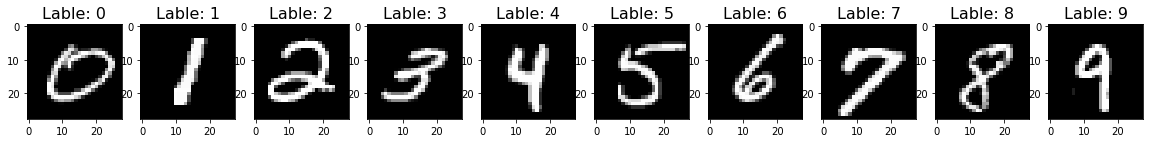

In [3]:
f, ax = plt.subplots(1, num_classes, figsize=(20,20))

for i in range(num_classes):
    sample = x_train[y_train == i][0]
    ax[i].imshow(sample, cmap='gray')
    ax[i].set_title('Lable: {}'.format(i), fontsize=16)

In [4]:
num_samples = []
for x in range(num_classes):
    num_samples.append(len(np.where(y_train==x)[0]))
print(num_samples)

[4748, 5420, 4784, 4912, 4666, 4317, 4741, 4966, 4691, 4755]


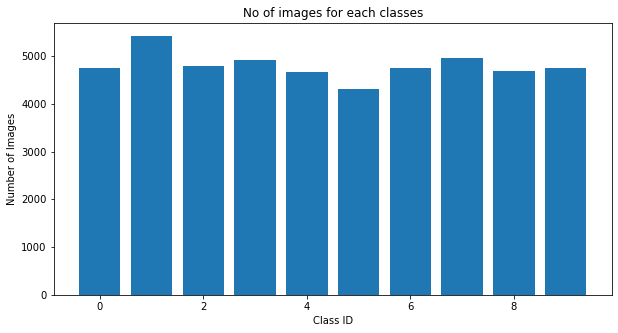

In [5]:
plt.figure(figsize=(10,5))
plt.bar(range(0,num_classes), num_samples)
plt.title('No of images for each classes')
plt.xlabel("Class ID")
plt.ylabel('Number of Images')
plt.show()

# PreProcessing

In [6]:
def preProcessing(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.bitwise_not(img)
#     img = cv2.equalizeHist(img)
    img = img / 255.
#     plt.imshow(img, cmap=plt.cm.binary)
    return img

In [7]:
# Normalize Data
x_train = np.array(list(map(preProcessing, x_train)))
x_test = np.array(list(map(preProcessing, x_test)))
x_val = np.array(list(map(preProcessing, x_val)))

In [8]:
# reshape images
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)

print('reshape {}'.format(x_train.shape))

reshape (48000, 28, 28, 1)


In [9]:
dataGen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                          height_shift_range=0.1,
                                                          zoom_range=0.2,
                                                          shear_range=0.1,
                                                          rotation_range=10)

In [10]:
dataGen.fit(x_train)

In [11]:
# before processing
for i in range(10):
    print(y_train[i])

5
0
1
6
1
3
8
8
1
8


In [12]:
# after one-hot enconding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

for i in range(10):
    print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# Model

In [13]:
model = tf.keras.models.Sequential()

model.add((tf.keras.layers.Conv2D(60, (5,5), input_shape=(28,28,1), activation='relu')))
model.add((tf.keras.layers.Conv2D(60, (5,5), activation='relu')))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add((tf.keras.layers.Conv2D(30, (3,3), activation='relu')))
model.add((tf.keras.layers.Conv2D(30, (3,3), activation='relu')))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                    

In [15]:
history = model.fit(dataGen.flow(x_train, y_train), epochs=10, validation_data=(x_val, y_val), shuffle=1)

Epoch 1/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.4886 - accuracy: 0.8429 - val_loss: 0.0679 - val_accuracy: 0.9797
Epoch 2/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1795 - accuracy: 0.9468 - val_loss: 0.0507 - val_accuracy: 0.9855
Epoch 3/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1361 - accuracy: 0.9605 - val_loss: 0.0418 - val_accuracy: 0.9887
Epoch 4/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1159 - accuracy: 0.9656 - val_loss: 0.0418 - val_accuracy: 0.9887
Epoch 5/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.1038 - accuracy: 0.9705 - val_loss: 0.0450 - val_accuracy: 0.9880
Epoch 6/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.0946 - accuracy: 0.9725 - val_loss: 0.0426 - val_accuracy: 0.9902
Epoch 7/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.0898 - accuracy: 0.9741 - val_loss: 0.0369 -

# Evaluate

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

Test Loss: 0.02741091698408127, Test Accuracy: 0.9923999905586243


In [17]:
# Graph
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
# Graph
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

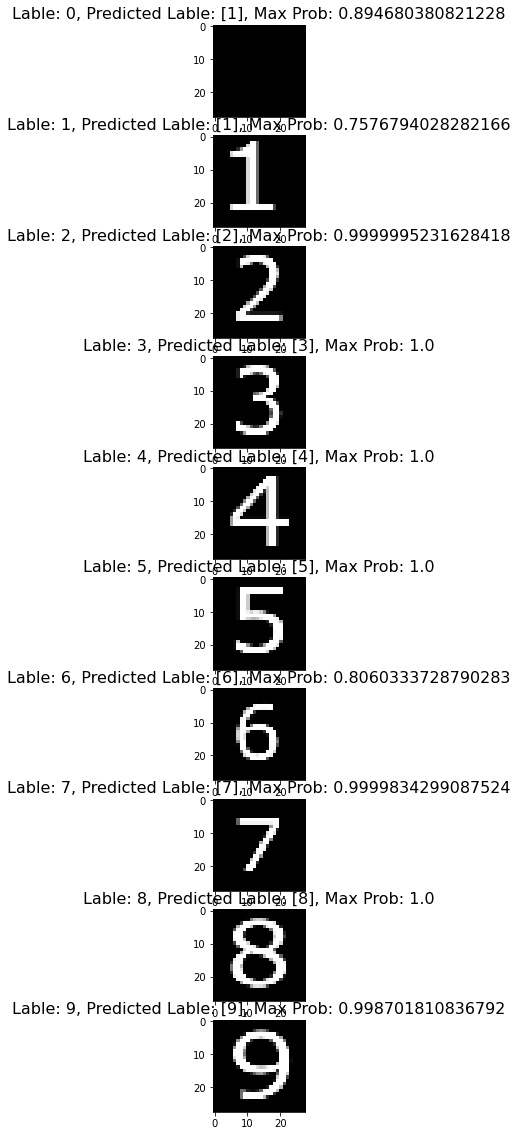

In [18]:
f, ax = plt.subplots(num_classes, 1, figsize=(20,20))
    
    
for i in range(10):
    testImage = cv2.imread(f'digit/{i}.PNG')
    testImage = np.asarray(testImage)
    testImage = cv2.resize(testImage, (28,28))

    testImage = preProcessing(testImage)
    testImage = testImage.reshape(1,28,28,1)
    
    # predict
    prediction=model.predict(testImage) 
    predictProb=np.amax(prediction)
    classes_x=np.argmax(prediction,axis=1)
    
    # plot
    testImage = testImage.reshape(28,28)
    ax[i].imshow(testImage, cmap='gray')
    ax[i].set_title('Lable: {}, Predicted Lable: {}, Max Prob: {}'.format(i,classes_x,predictProb), fontsize=16)

In [27]:
# testImage = cv2.imread('digit/6.PNG')
testImage = cv2.imread('digit/5.PNG')

testImage = np.asarray(testImage)
testImage = cv2.resize(testImage, (28,28))

print('Input Shape: ',testImage.shape)
testImage = preProcessing(testImage)

testImage = testImage.reshape(1,28,28,1)
# predict
prediction=model.predict(testImage) 
predictProb=np.amax(prediction)
classes_x=np.argmax(prediction,axis=1)
print('Predicted Class: ',classes_x)
print('Max Prob: ',predictProb)
# cv2.imshow('prepossed image', testImage)
# cv2.waitKey(0)

Input Shape:  (28, 28, 3)
Predicted Class:  [5]
Max Prob:  1.0


In [ ]:
testImage = cv2.imread('sample_image.png')
testImage = np.asarray(testImage)
testImage = cv2.resize(testImage, (28,28))
testImage = preProcessing(testImage)
testImage = testImage.reshape(1,28,28,1)
# predict
prediction=model.predict(testImage) 
classes_x=np.argmax(prediction,axis=1)
print(classes_x)
# cv2.imshow('prepossed image', testImage)
# cv2.waitKey(0)

# Live Prediction

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import tensorflow as tf

In [2]:
def getPrediction(frame, model):
    frame = np.asarray(frame)
    frame = cv2.resize(frame, (28,28))
    
    # pre-processing
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.bitwise_not(frame)
    frame = frame / 255.
    frame = frame.reshape(1,28,28,1)
    
    # predict
    prediction = model.predict(frame) 
    predictProb = np.amax(prediction)
    classes_x = np.argmax(prediction,axis=1)
    return classes_x, predictProb

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

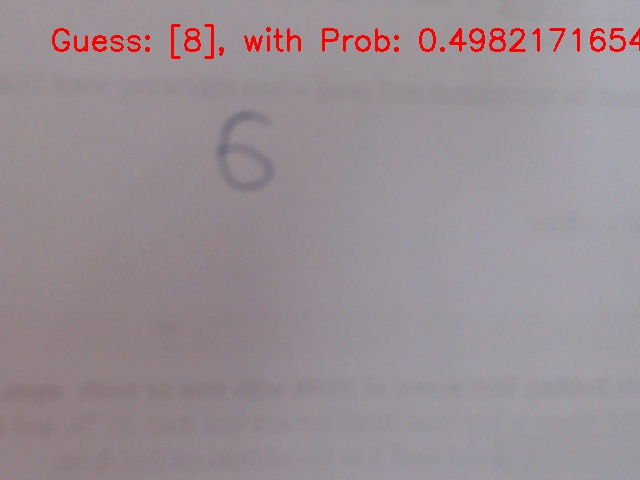

In [6]:
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
#         frame = cv2.flip(frame, 1) # if your camera reverses your image
        
        # find the prediction
        predic_class, predic_prob = getPrediction(frame=frame, model=model)
         
        # describe the type of font
        # to be used.
        font = cv2.FONT_HERSHEY_SIMPLEX

        # Use putText() method for
        # inserting text on video
        cv2.putText(frame, 
                    f"Guess: {predic_class}, with Prob: {predic_prob}", 
                    (50, 50), 
                    font, 1, 
                    (0, 0, 255), 
                    2, 
                    cv2.LINE_4)
        
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
       
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

In [5]:
model = tf.keras.models.load_model('mnist-nn.h5')

In [61]:
model.save('mnist-nn.h5')